# Transfer Learning

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [18]:
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [14]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Connect to kaggle
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
# Get Dataset form kaggle
!kaggle datasets download -d arkadiyhacks/drinking-waste-classification
!unzip -q drinking-waste-classification.zip -d .

 99% 1.48G/1.50G [00:09<00:00, 193MB/s]
100% 1.50G/1.50G [00:10<00:00, 159MB/s]


In [19]:
data_dir = "/content/Images_of_Waste/rawimgs/"

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=100,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 4820 files belonging to 4 classes.
Using 3856 files for training.
Found 4820 files belonging to 4 classes.
Using 964 files for validation.


In [20]:
do_fine_tuning = True

In [22]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,228,996
Non-trainable params: 34,112
_________________________________________________________________


In [24]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [25]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


241/241 [==============================] - 42s 143ms/step - loss: 0.7468 - accuracy: 0.8561 - val_loss: 0.6378 - val_accuracy: 0.9208
Epoch 2/5
241/241 [==============================] - 33s 135ms/step - loss: 0.5200 - accuracy: 0.9754 - val_loss: 0.4911 - val_accuracy: 0.9771
Epoch 3/5
241/241 [==============================] - 33s 136ms/step - loss: 0.4809 - accuracy: 0.9922 - val_loss: 0.4730 - val_accuracy: 0.9844
Epoch 4/5
241/241 [==============================] - 33s 136ms/step - loss: 0.4611 - accuracy: 0.9974 - val_loss: 0.4672 - val_accuracy: 0.9865
Epoch 5/5
241/241 [==============================] - 33s 136ms/step - loss: 0.4511 - accuracy: 0.9990 - val_loss: 0.4670 - val_accuracy: 0.9844


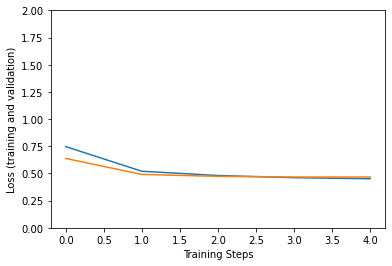

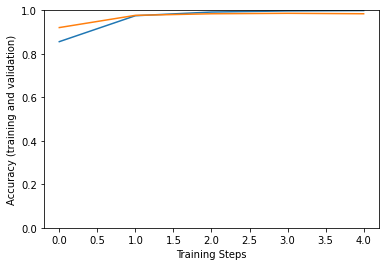

In [26]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

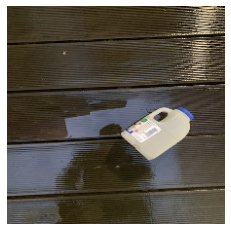

[[0.01946128 0.01762128 0.93844175 0.02447569]]
True label: HDPEM
Predicted label: HDPEM


In [30]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print(model.predict(np.expand_dims(image, axis=0)))
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [28]:
# Save Model
model.save("model.h5")

# Convert to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('waste.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8hr9ekvc/assets


INFO:tensorflow:Assets written to: /tmp/tmp8hr9ekvc/assets
